# Transformer Blog
- toc: true 
- badges: true
- comments: true
- sticky_rank: 2
- author: Bowen
- categories: [pytorch, fastai]

reference links which helps a lot:
  - [1] http://jalammar.github.io/illustrated-transformer/
  - [2] http://peterbloem.nl/blog/transformers
  - [3] https://nlp.seas.harvard.edu/2018/04/03/attention.html


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

## self-attention method

![](https://i.loli.net/2021/01/11/D2rtu9nGSVbdAUq.png)

![](https://i.loli.net/2021/01/11/VW1UubNORzTy7E6.png)

In [18]:
x = torch.randn(2,3,4)
raw_weights = torch.bmm(x,x.transpose(1,2))
weights = F.softmax(raw_weights,dim=2)
weights

tensor([[[3.7608e-01, 1.4019e-01, 4.8374e-01],
         [1.3241e-02, 9.8102e-01, 5.7356e-03],
         [6.7872e-02, 8.5199e-03, 9.2361e-01]],

        [[8.6212e-01, 1.9809e-02, 1.1807e-01],
         [6.0491e-04, 9.8575e-01, 1.3647e-02],
         [1.1610e-01, 4.3942e-01, 4.4448e-01]]])

In [19]:
y = torch.bmm(weights,x)
y

tensor([[[ 0.7534,  0.1771, -0.0526, -0.4511],
         [ 0.0585, -1.1643,  1.3854,  0.4464],
         [ 1.2452,  0.3228, -0.4401, -0.9620]],

        [[-0.8668,  0.0406,  0.0529, -0.2900],
         [ 1.9601, -0.1198, -0.9540,  0.3403],
         [ 0.9987, -0.2199, -0.2520, -0.0090]]])

In [40]:
torch.random.seed()
temp = torch.randint(0,2,(2,2))
temp
yy = F.softmax(temp.float(),dim=0)
yy

4912394464713312614

tensor([[1, 1],
        [0, 1]])

tensor([[0.7311, 0.5000],
        [0.2689, 0.5000]])

![](https://i.loli.net/2021/01/11/IshpEO5UHlXvw8k.png)



In [4]:
aa = np.random.randint(1,10,(3,4))
aa

array([[2, 9, 7, 7],
       [2, 3, 3, 4],
       [2, 2, 8, 9]])

In [9]:
aa[:,0::2]

array([[2, 7],
       [2, 3],
       [2, 8]])

## multi-head attention

In [43]:
class SelfAttentionWide(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)

class SelfAttentionNarrow(nn.Module):

    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        assert emb % heads == 0, f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'

        self.emb = emb
        self.heads = heads
        self.mask = mask

        s = emb // heads
        # - We will break the embedding into `heads` chunks and feed each to a different attention head

        self.tokeys    = nn.Linear(s, s, bias=False)
        self.toqueries = nn.Linear(s, s, bias=False)
        self.tovalues  = nn.Linear(s, s, bias=False)

        self.unifyheads = nn.Linear(heads * s, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        s = e // h
        x = x.view(b, t, h, s)

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)

        assert keys.size() == (b, t, h, s)
        assert queries.size() == (b, t, h, s)
        assert values.size() == (b, t, h, s)

        # Compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)

        return self.unifyheads(out)

we can also change the code using einsum which help to short the code part and have a nice execution time https://rockt.github.io/2018/04/30/einsum

In [44]:
class SelfAttentionWideEinsum(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)
    def forward_einsum(self, x):
        b, t, e = x.size()
        h = self.heads

        keys    = self.tokeys(x).view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x).view(b, t, h, e)

        dot = torch.einsum('bthe,bihe->bhti', queries, keys) / math.sqrt(e)
        dot = F.softmax(dot, dim=-1)

        out = torch.einsum('bhtd,bdhe->bthe', dot, values)

        # we can move reshape of weights to init; I left it here just to compare with the original implementation
        out = torch.einsum('bthe,khe->btk', out, self.unifyheads.weight.view(e,h,e)) 
        return out + self.unifyheads.bias

## transformer structure

![](https://i.loli.net/2021/01/11/ri7wu9jPdohARF1.png)

In [45]:
class TransformerBlock(nn.Module):

    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, wide=True):
        super().__init__()

        self.attention = SelfAttentionWide(emb, heads=heads, mask=mask) if wide \
                    else SelfAttentionNarrow(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)
'''
We’ve made the relatively arbitrary choice of making the hidden layer
of the feedforward 4 times as big as the input and output. Smaller values may work as well, 
and save memory, but it should be bigger than the input/output layers.
'''
        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x

## position embedding 

In [47]:
def d(tensor=None):
    """
    Returns a device string either for the best available device,
    or for the device corresponding to the argument
    :param tensor:
    :return:
    """
    if tensor is None:
        return 'cuda' if torch.cuda.is_available() else 'cpu'
    return 'cuda' if tensor.is_cuda else 'cpu'

In [54]:
temp = torch.randn(2,3,4)
temp

tensor([[[-0.9651,  1.4951, -0.0168,  0.7085],
         [-1.9934, -0.5921, -0.3682, -0.8308],
         [ 1.0251, -0.0033, -1.4288,  0.4307]],

        [[-0.1145,  0.4717, -0.5771,  0.8367],
         [ 0.8415, -0.2907,  2.7137, -0.3131],
         [ 1.2084,  0.0839, -0.4571, -0.1604]]])

In [67]:
>>> # an Embedding module containing 10 tensors of size 6
>>> embedding = nn.Embedding(10, 6)
>>> # a batch of 2 samples of 4 indices each
>>> input = torch.LongTensor([[1,2,3]])
>>> embedding(input)

tensor([[[-1.0416, -1.2013, -1.1024, -0.2295,  0.7987,  0.5698],
         [-0.9966,  0.5302, -0.6908, -2.4040, -0.1549, -0.0050],
         [ 0.1405, -0.4664, -0.2933, -0.0160,  0.0548, -0.3741]]],
       grad_fn=<EmbeddingBackward>)

In [56]:
temp[None,:,:].shape

torch.Size([1, 2, 3, 4])

In [69]:
b,t,e = 3,5,6
position = nn.Embedding(10,6)(torch.arange(t))[None, :, :].expand(b, t, e)
position

tensor([[[-1.6559, -0.3209,  2.2730,  0.3641, -1.5789, -1.0718],
         [-0.3217,  0.2345,  1.8767, -0.8459, -1.0136,  0.1944],
         [ 0.2643, -1.5120, -0.1799,  1.8587,  0.7489,  0.0663],
         [-0.2499,  0.6199,  0.6119, -0.1948, -1.2249, -0.9786],
         [-0.0888,  1.4573, -0.0139, -1.5792,  1.0114, -0.6898]],

        [[-1.6559, -0.3209,  2.2730,  0.3641, -1.5789, -1.0718],
         [-0.3217,  0.2345,  1.8767, -0.8459, -1.0136,  0.1944],
         [ 0.2643, -1.5120, -0.1799,  1.8587,  0.7489,  0.0663],
         [-0.2499,  0.6199,  0.6119, -0.1948, -1.2249, -0.9786],
         [-0.0888,  1.4573, -0.0139, -1.5792,  1.0114, -0.6898]],

        [[-1.6559, -0.3209,  2.2730,  0.3641, -1.5789, -1.0718],
         [-0.3217,  0.2345,  1.8767, -0.8459, -1.0136,  0.1944],
         [ 0.2643, -1.5120, -0.1799,  1.8587,  0.7489,  0.0663],
         [-0.2499,  0.6199,  0.6119, -0.1948, -1.2249, -0.9786],
         [-0.0888,  1.4573, -0.0139, -1.5792,  1.0114, -0.6898]]],
       grad_fn=<Exp

## position encoding

In [2]:
# Code from https://www.tensorflow.org/tutorials/text/transformer
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return pos_encoding

(1, 10, 64)


<Figure size 864x576 with 0 Axes>

Text(0.5, 0, 'Embedding Dimensions')

(0.0, 64.0)

(10.0, 0.0)

Text(0, 0.5, 'Token Position')

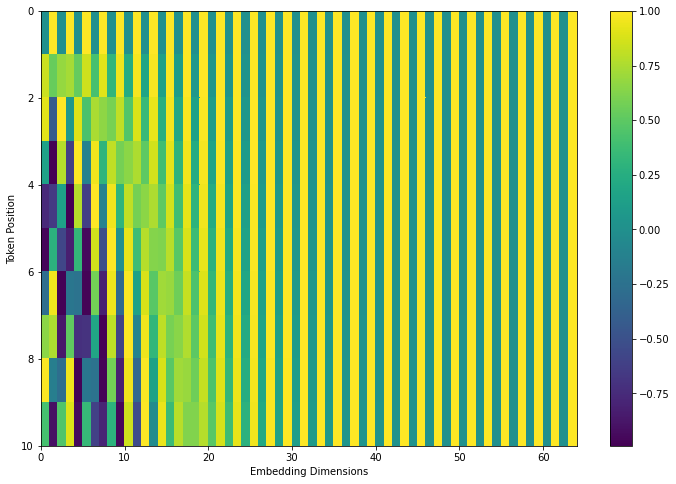

In [11]:
tokens = 10
dimensions = 64

pos_encoding = positional_encoding(tokens, dimensions)
print (pos_encoding.shape)

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_encoding[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.ylim((tokens,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()


## Transformer structure

In [15]:
class Transformer(nn.Module):
    def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
        super().__init__()

        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, k)
        self.pos_emb = nn.Embedding(seq_length, k)

		# The sequence of transformer blocks that does all the 
		# heavy lifting
        tblocks = []
        for i in range(depth):
            tblocks.append(TransformerBlock(k=k, heads=heads))
        self.tblocks = nn.Sequential(*tblocks)

		# Maps the final output sequence to class logits
        self.toprobs = nn.Linear(k, num_classes)

    def forward(self, x):
        """
        :param x: A (b, t) tensor of integer values representing 
                  words (in some predetermined vocabulary).
        :return: A (b, c) tensor of log-probabilities over the 
                 classes (where c is the nr. of classes).
        """
		# generate token embeddings
        tokens = self.token_emb(x)
        b, t, k = tokens.size()

		# generate position embeddings
        positions = torch.arange(t)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)
        
        x = tokens + positions
        x = self.tblocks(x)
        
        # Average-pool over the t dimension and project to class 
        # probabilities
        x = self.toprobs(x.mean(dim=1))
        return F.log_softmax(x, dim=1)

## mask

![](https://i.loli.net/2021/01/12/PshiNdajJzu6oOR.png)

- https://pytorch.org/docs/stable/generated/torch.triu.html#torch.triu
https://pytorch.org/docs/stable/generated/torch.triu_indices.html#torch.triu_indices

In [18]:
iu1 = np.triu_indices(4)
iu2 = np.triu_indices(4,2)
iu1
# iu2

(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([0, 1, 2, 3, 1, 2, 3, 2, 3, 3]))

In [20]:
a = np.arange(16).reshape(4,4)
a[iu1]

array([ 0,  1,  2,  3,  5,  6,  7, 10, 11, 15])

In [21]:
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [22]:
a[iu2]

array([2, 3, 7])

In [29]:
iu1 = torch.triu_indices(4,4)
a = torch.arange(16).view(4,4)
a 
iu1

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
        [0, 1, 2, 3, 1, 2, 3, 2, 3, 3]])

In [31]:
a[iu1[0],iu1[1]]

tensor([ 0,  1,  2,  3,  5,  6,  7, 10, 11, 15])

In [32]:
# mask function
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false
    In place operation
    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices[0], indices[1]] = maskval

In [42]:
queries = torch.randn(1,3,3)
keys = torch.randn(1,3,3)
t = 3
dot = torch.bmm(queries, keys.transpose(1, 2))

indices = torch.triu_indices(t, t, offset=1)
dot[:, indices[0], indices[1]] = float('-inf')

dot = F.softmax(dot, dim=2) 
indices
dot
dot[:, indices[0], indices[1]]

tensor([[0, 0, 1],
        [1, 2, 2]])

tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00],
         [9.0848e-01, 9.1524e-02, 0.0000e+00],
         [2.5938e-04, 9.9937e-01, 3.6845e-04]]])

tensor([[0., 0., 0.]])